# __Alerta de Transações__


## __1. Análise Exploratória__

### Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller


from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler

from joblib import dump


X_TICKS = ["00 00", "06 00", "12 00", "18 00"]

import warnings
warnings.filterwarnings("ignore")

### Carregando arquivos

In [2]:
URL = "https://raw.githubusercontent.com/Colin-Riley/monitoring/main/transacoes_reversed_minuto_a_minuto_fis_cw__desfazimentos__2022-02-22T21_16_12.064248Z.csv"

df = pd.read_csv(URL)
df.head()

,f0_,status,f1_
0,00h 00,denied,8
1,00h 00,approved,15
2,00h 01,refunded,1
3,00h 01,denied,6
4,00h 01,approved,9


In [3]:
df.shape

(3175, 3)

In [5]:
df.dtypes

f0_       object
status    object
f1_        int64
dtype: object

### Renomeando Colunas

In [6]:
df.rename(columns={"f0_":"horario", "f1_":"transacoes"}, inplace=True)
df.head()

,horario,status,transacoes
0,00h 00,denied,8
1,00h 00,approved,15
2,00h 01,refunded,1
3,00h 01,denied,6
4,00h 01,approved,9


### Modificando coluna com informações de tempo 

In [7]:
df.horario = pd.to_datetime(df.horario, format="%Hh %M").dt.strftime("%H %M")

In [8]:
df.tail()

,horario,status,transacoes
3170,18 58,approved,232
3171,18 59,denied,38
3172,18 59,reversed,2
3173,18 59,refunded,1
3174,18 59,approved,239


### Pivotando tabela

In [9]:
df_pivoted = df.pivot(index="horario", columns="status", values="transacoes")

In [10]:
df_pivoted.head()

status,approved,backend_reversed,denied,echo,failed,processing,refunded,reversed
horario,,,,,,,,
00 00,15.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN
00 01,9.0,NaN,6.0,NaN,NaN,NaN,1.0,NaN
00 02,18.0,NaN,5.0,3.0,NaN,NaN,1.0,NaN
00 03,11.0,NaN,4.0,NaN,NaN,NaN,1.0,NaN
00 04,16.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN


In [11]:
df_pivoted.to_csv("dados/pivoted_transactions.csv")

### Selecionando Variáveis

In [12]:
df_pivoted.isna().sum()

status
approved              23
backend_reversed     927
denied               148
echo                 995
failed              1069
processing          1075
refunded             685
reversed             519
dtype: int64

In [13]:
df_pivoted["total_reversed"] = df_pivoted["backend_reversed"] + df_pivoted["reversed"]
df_pivoted.head()

status,approved,backend_reversed,denied,echo,failed,processing,refunded,reversed,total_reversed
horario,,,,,,,,,
00 00,15.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
00 01,9.0,NaN,6.0,NaN,NaN,NaN,1.0,NaN,NaN
00 02,18.0,NaN,5.0,3.0,NaN,NaN,1.0,NaN,NaN
00 03,11.0,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN
00 04,16.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_pivoted.shape

(1077, 9)

In [15]:
df_pivoted.isna().sum()

status
approved              23
backend_reversed     927
denied               148
echo                 995
failed              1069
processing          1075
refunded             685
reversed             519
total_reversed       961
dtype: int64

In [16]:
valid_columns = ["approved", "total_reversed", "denied", "failed"]

In [17]:
df_pivoted.fillna(0, inplace=True)

In [18]:
df_pivoted["total_reversed"] = df_pivoted["backend_reversed"] + df_pivoted["reversed"]
df_pivoted.head()

status,approved,backend_reversed,denied,echo,failed,processing,refunded,reversed,total_reversed
horario,,,,,,,,,
00 00,15.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
00 01,9.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
00 02,18.0,0.0,5.0,3.0,0.0,0.0,1.0,0.0,0.0
00 03,11.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
00 04,16.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


### Gráficos das Séries Temporais e Histogramas

In [19]:
def plota_graficos(column, data, diff=False):
    values = data[column]
    if diff:
        values = data[column].diff()

    fig, ax = plt.subplots(2, figsize=(16,8))
    fig.suptitle("{} - Série Temporal".format(column.capitalize()))
    sns.lineplot(x=data.index, y=values, ax=ax[0])
    ax[0].set_xticks(["00 00", "06 00", "12 00", "18 00"])
    sns.histplot(x=values.replace(0, np.NaN), ax=ax[1], kde=True, bins=8)



#### Gráficos de Transações Aprovadas

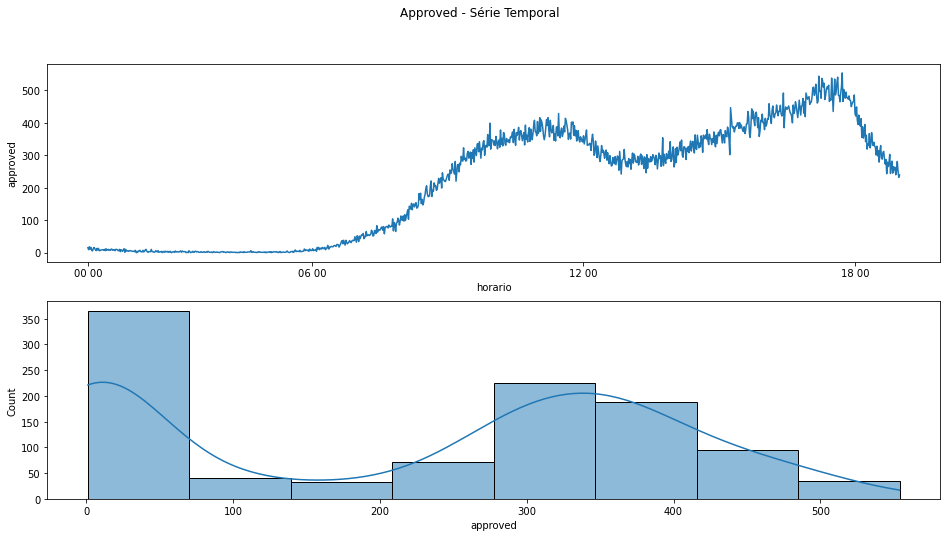

In [20]:
plota_graficos("approved", data=df_pivoted)

#### Gráficos de Transações Falhas

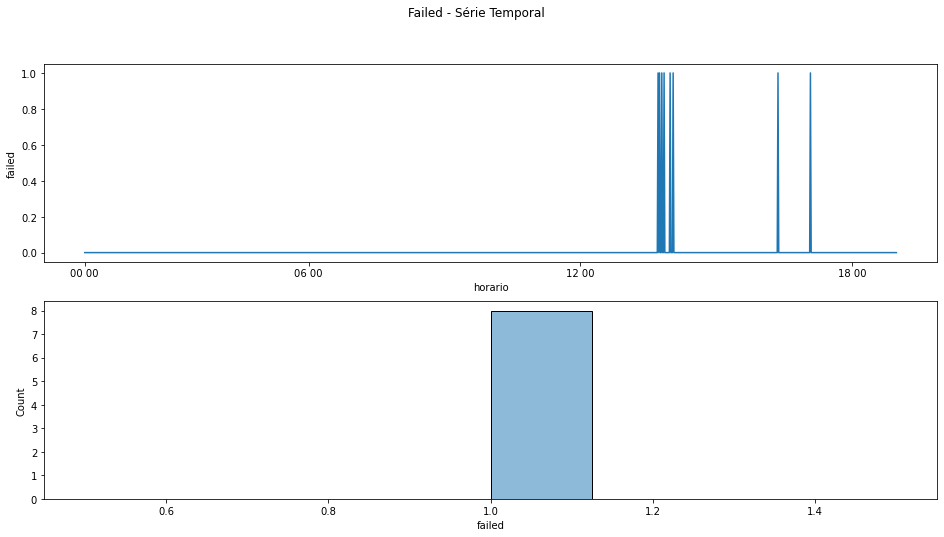

In [21]:
plota_graficos("failed", data=df_pivoted)

#### Gráfico de Transações Negadas

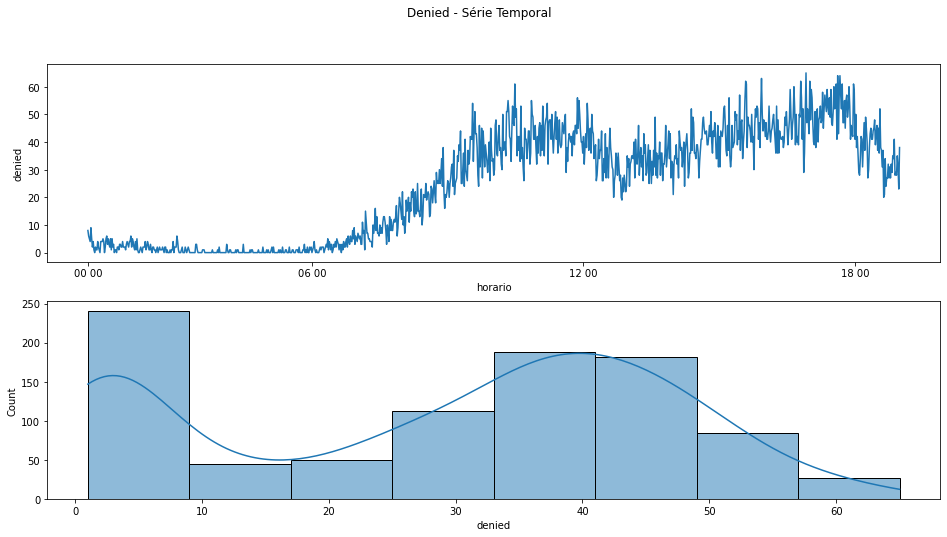

In [22]:
plota_graficos("denied", data=df_pivoted)

#### Gráfico de Transações Revertidas

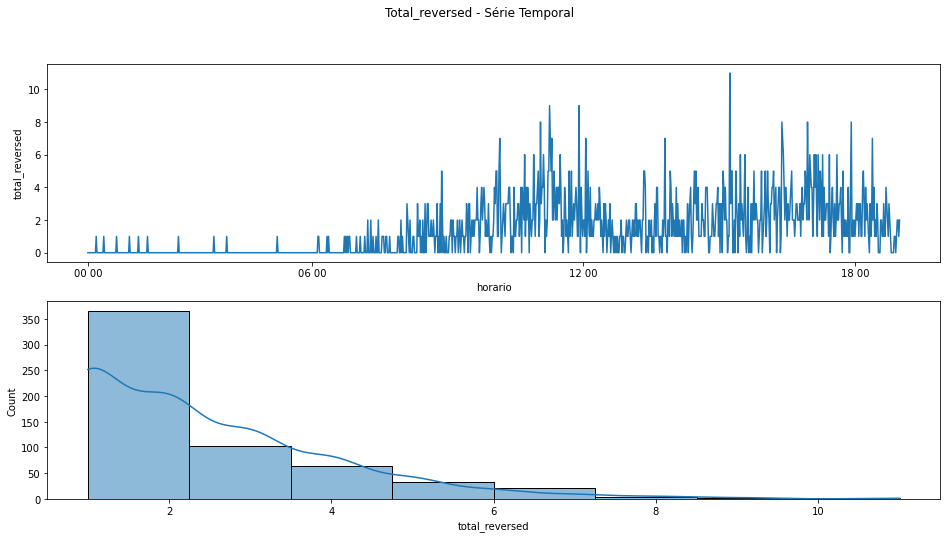

In [23]:
plota_graficos("total_reversed", data=df_pivoted)

#### Gráfico de Differencial das Transações

#### Gráfico de Transações Aprovadas - Diferencial

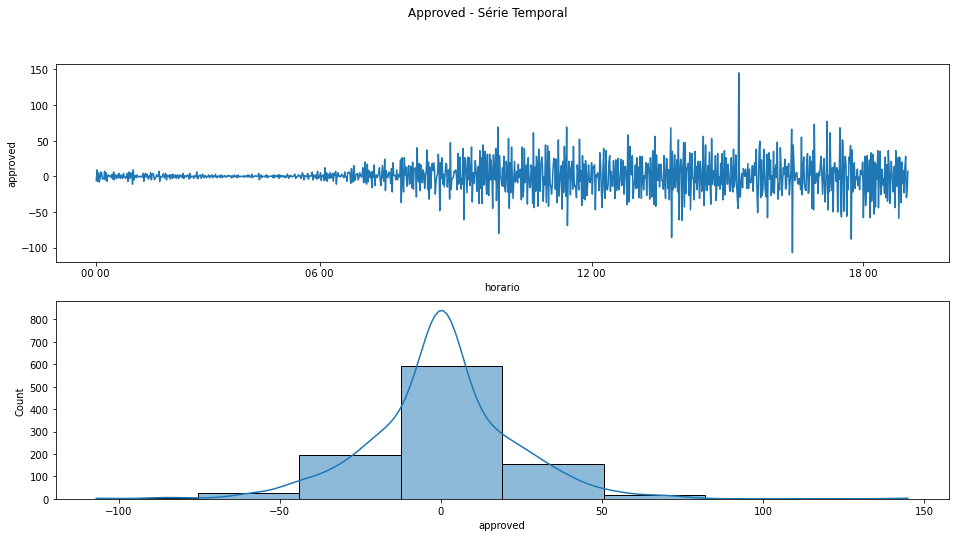

In [24]:
plota_graficos("approved", data=df_pivoted, diff=True)

#### Gráfico das Transações Falhas - Diferencial  

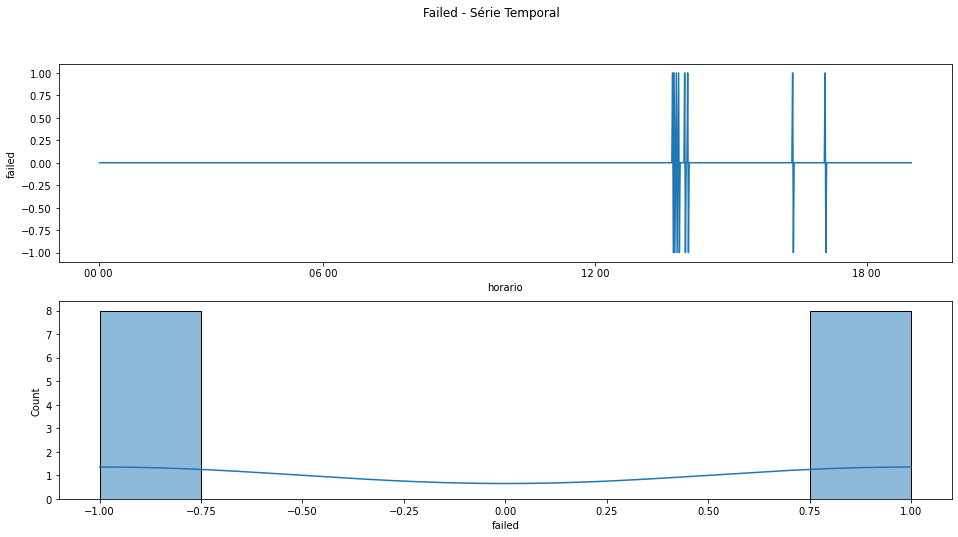

In [25]:
plota_graficos("failed", data=df_pivoted, diff=True)

#### Gráfico das Transações Negadas - Diferencial

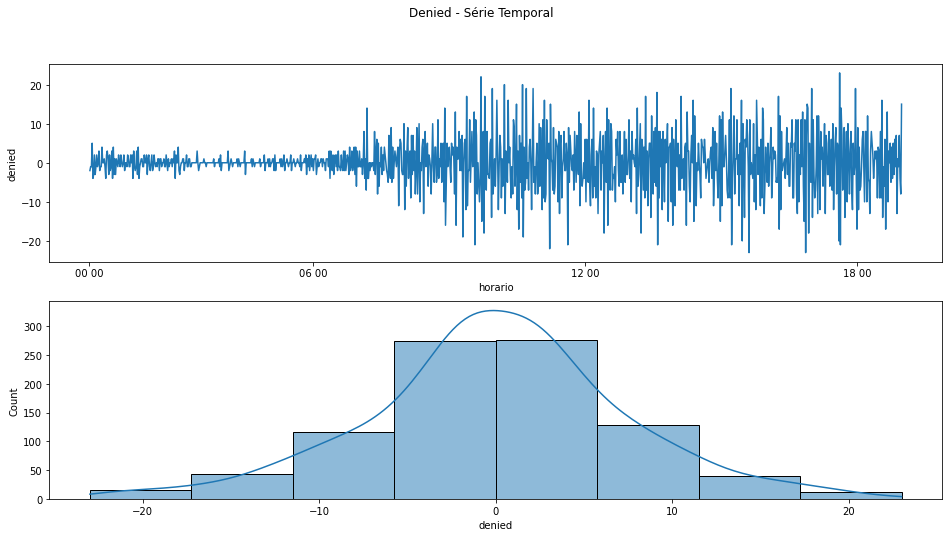

In [26]:
plota_graficos("denied", data=df_pivoted, diff=True)

#### Gráfico das Transações Revertidas - Diferencial

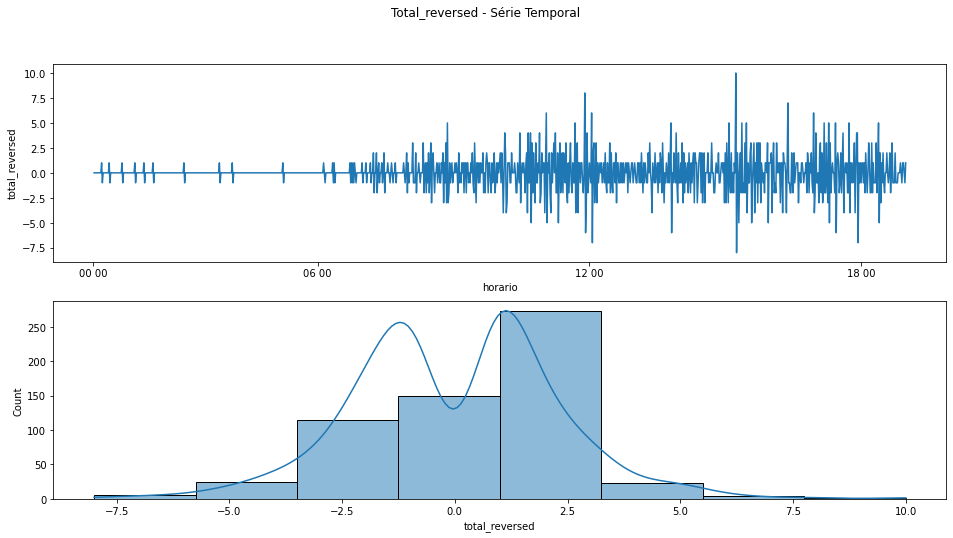

In [27]:
plota_graficos("total_reversed", data=df_pivoted, diff=True)

## Testando Estacionaridade

In [28]:
def testa_estacionaridade(series):
    
    # Calcula estatísticas móveis
    rolmean = series.rolling(window = 15).mean()
    rolstd = series.rolling(window = 15).std()

    # Plot das estatísticas móveis
    orig = plt.plot(series, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(series, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, a série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, a série provavelmente é estacionária.')

#### Testa Estacionaridade de Transações Aprovadas

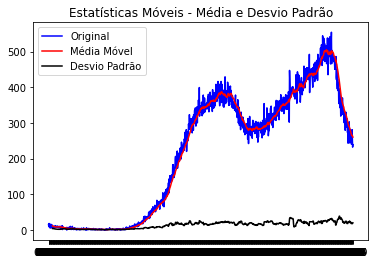


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -1.349557
Valor-p                            0.606206
Número de Lags Consideradas       19.000000
Número de Observações Usadas    1057.000000
Valor Crítico (1%)                -3.436552
Valor Crítico (5%)                -2.864278
Valor Crítico (10%)               -2.568228
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, a série provavelmente não é estacionária.


In [29]:
testa_estacionaridade(df_pivoted["approved"])

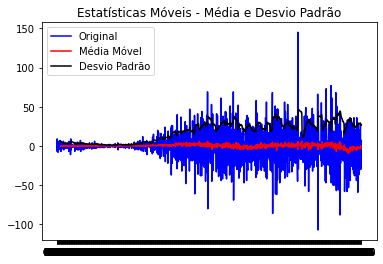


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -3.766437
Valor-p                            0.003270
Número de Lags Consideradas       22.000000
Número de Observações Usadas    1053.000000
Valor Crítico (1%)                -3.436575
Valor Crítico (5%)                -2.864289
Valor Crítico (10%)               -2.568234
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, a série provavelmente é estacionária.


In [30]:
testa_estacionaridade(df_pivoted["approved"].diff().dropna())

#### Testa Estacionaridade de Transações Falhas

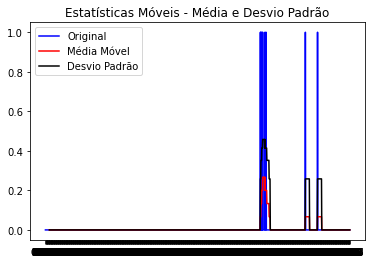


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -5.609001
Valor-p                            0.000001
Número de Lags Consideradas       22.000000
Número de Observações Usadas    1054.000000
Valor Crítico (1%)                -3.436569
Valor Crítico (5%)                -2.864286
Valor Crítico (10%)               -2.568232
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, a série provavelmente é estacionária.


In [31]:
testa_estacionaridade(df_pivoted["failed"].dropna())

#### Testa Etacionaridade de Transações Negadas

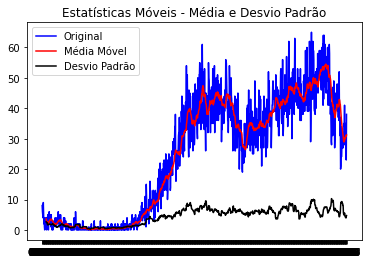


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -1.200214
Valor-p                            0.673504
Número de Lags Consideradas       14.000000
Número de Observações Usadas    1062.000000
Valor Crítico (1%)                -3.436522
Valor Crítico (5%)                -2.864265
Valor Crítico (10%)               -2.568221
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, a série provavelmente não é estacionária.


In [32]:
testa_estacionaridade(df_pivoted["denied"].dropna())

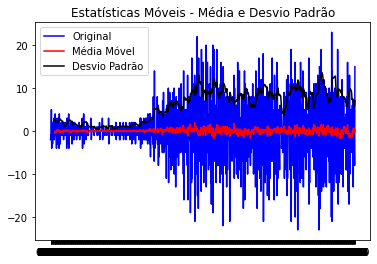


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -1.363306e+01
Valor-p                         1.708704e-25
Número de Lags Consideradas     1.300000e+01
Número de Observações Usadas    1.062000e+03
Valor Crítico (1%)             -3.436522e+00
Valor Crítico (5%)             -2.864265e+00
Valor Crítico (10%)            -2.568221e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, a série provavelmente é estacionária.


In [33]:
testa_estacionaridade(df_pivoted["denied"].diff().dropna())

#### Testa Estacionaridade de Transações Revertidas

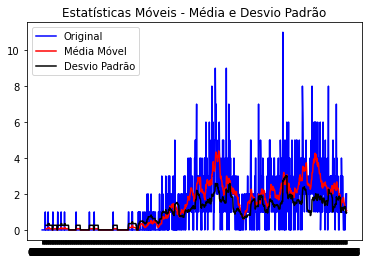


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -2.133232
Valor-p                            0.231364
Número de Lags Consideradas       17.000000
Número de Observações Usadas    1059.000000
Valor Crítico (1%)                -3.436540
Valor Crítico (5%)                -2.864273
Valor Crítico (10%)               -2.568225
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, a série provavelmente não é estacionária.


In [34]:
testa_estacionaridade(df_pivoted["total_reversed"])

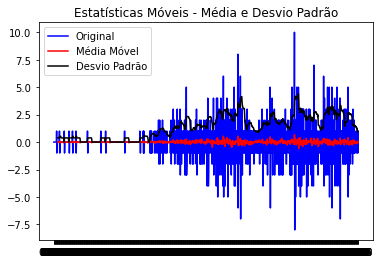


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -1.306741e+01
Valor-p                         1.989177e-24
Número de Lags Consideradas     1.600000e+01
Número de Observações Usadas    1.059000e+03
Valor Crítico (1%)             -3.436540e+00
Valor Crítico (5%)             -2.864273e+00
Valor Crítico (10%)            -2.568225e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, a série provavelmente é estacionária.


In [35]:
testa_estacionaridade(df_pivoted["total_reversed"].diff().dropna())

## Referendo da Análise 
- Os dados de transações **falhas** possuem pouca informação, portanto, é improvável a contrução de um modelo robusto para detecção de anomalias.
- Os dados de transações **negadas** e **revertidas**, após um processo de imputação de dados e diferenciação, apresentam comportamento de uma série estacionária, logo é possível lançar mão de modelos estatístcos ou machine learning para a identificação de anomalias

## 2. Detecção de Anomalias

### Detecção de Outliers com Floresta de Isolamento

#### Detectando Anomalias em Transações Negadas

In [37]:
df_train = df_pivoted[["denied", "total_reversed"]].diff().dropna()
df_train.head()

status,denied,total_reversed
horario,,
00 01,-2.0,0.0
00 02,-1.0,0.0
00 03,-1.0,0.0
00 04,5.0,0.0
00 05,-4.0,0.0


In [38]:
denied_scaler = StandardScaler().fit(df_train.denied.values.reshape(-1,1))
x_denied = denied_scaler.transform(df_train.denied.values.reshape(-1,1))

<AxesSubplot:xlabel='horario'>

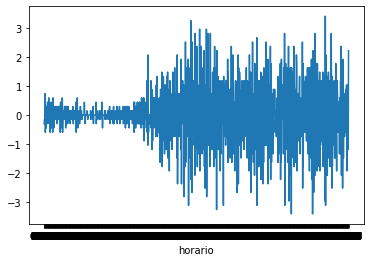

In [39]:
sns.lineplot(x=df_train.index, y = x_denied.reshape(-1))

In [56]:
STEPS = 15

def cria_sequencia(serie, steps):
    output = []
    for i in range(len(serie) - steps + 1):
        output.append(serie[i : (i + steps)])
    return np.stack(output)


x_denied_train = cria_sequencia(x_denied, steps=STEPS).reshape(-1, -1)
print("Training input shape: ", x_denied_train.shape)

ValueError: can only specify one unknown dimension

In [57]:
model_denied = IsolationForest(contamination=0.1, random_state=7).fit(x_denied)

In [58]:
df_pred_denied = model_denied.predict(x_denied)

In [59]:
df_pred_denied = np.concatenate((np.array([1]), df_pred_denied), axis=None)

In [61]:
df_pivoted["pred_denied"] = df_pred_denied

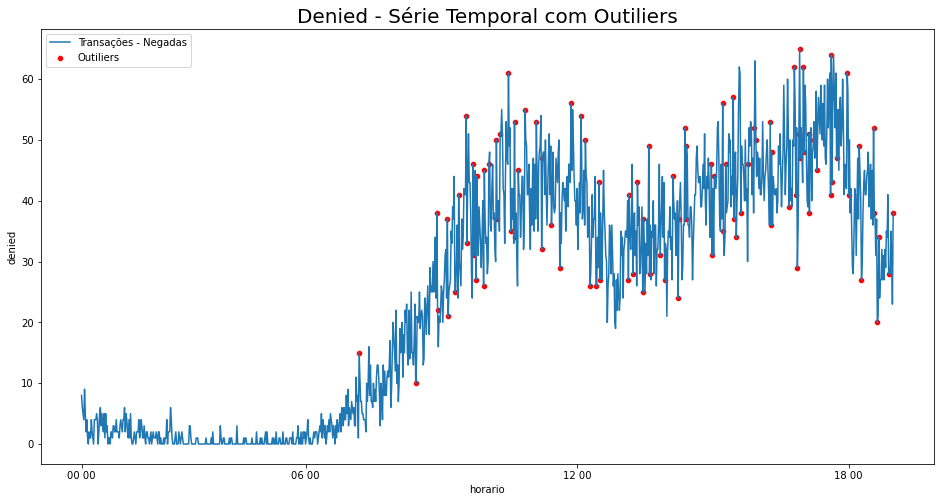

In [69]:
plt.figure(figsize=(16,8))
data=df_pivoted[df_pivoted.pred_denied == -1]
sns.lineplot(x=df_pivoted.index, y=df_pivoted.denied.values)
sns.scatterplot(x=data.index, y=data.denied, data=data, color="red")
plt.title("Denied - Série Temporal com Outiliers", fontsize=20)
plt.xticks(X_TICKS)
plt.legend(["Transações - Negadas", "Outiliers"])
plt.show()

#### Detecta Anomalias em Transações Revertidas

In [71]:
reversed_scaler = StandardScaler().fit(df_train.total_reversed.values.reshape(-1,1))
x_reversed = reversed_scaler.transform(df_train.total_reversed.values.reshape(-1,1))

<AxesSubplot:xlabel='horario'>

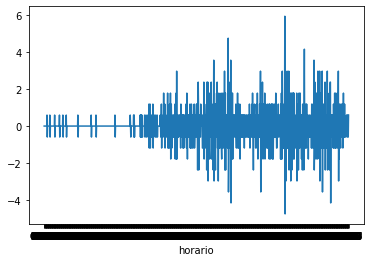

In [73]:
sns.lineplot(x=df_train.index, y = x_reversed.reshape(-1))

In [102]:
model_reversed = IsolationForest(contamination=0.05, random_state=7).fit(x_reversed)

In [103]:
df_pred_reversed = model_reversed.predict(x_denied)

In [104]:
df_pred_reversed = np.concatenate((np.array([1]), df_pred_reversed), axis=None)

In [105]:
df_pivoted["pred_reversed"] = df_pred_reversed

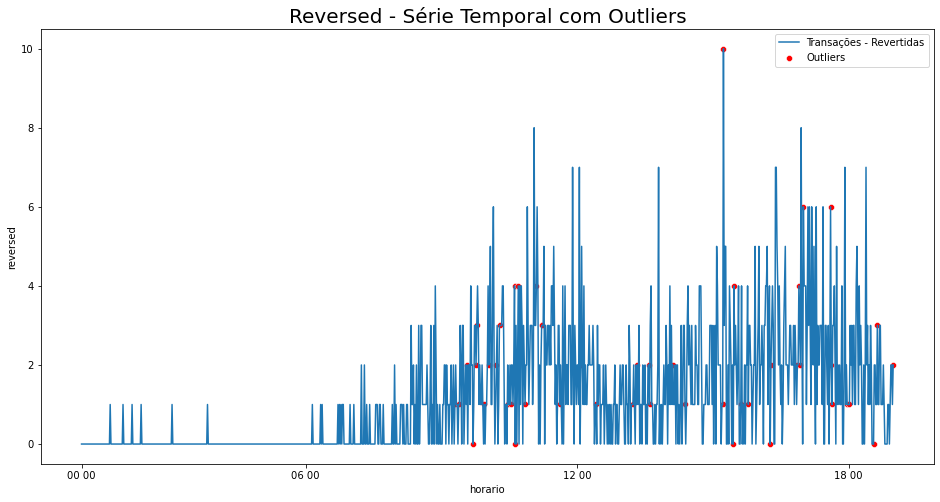

In [106]:
plt.figure(figsize=(16,8))
data=df_pivoted[df_pivoted.pred_reversed == -1]
sns.lineplot(x=df_pivoted.index, y=df_pivoted.reversed.values)
sns.scatterplot(x=data.index, y=data.reversed, data=data, color="red")
plt.title("Reversed - Série Temporal com Outliers", fontsize=20)
plt.xticks(X_TICKS)
plt.legend(["Transações - Revertidas", "Outliers"])
plt.show()

## Escolha para detecção de outliers em tempo real

- Para as transações "negadas" e "revertidas", utilizar o modelo de Florestas de isolamento
- Para as transações falhas, utilizar valor de threshold (2)

In [108]:
dump(model_denied, "models/model_denied.joblib")
dump(model_reversed, "models/model_reversed.joblib")
dump(denied_scaler, "models/scaler_denied.joblib")
dump(reversed_scaler, "models/scaler_reversed.joblib")

['models/scaler_reversed.joblib']